In [1]:
from quilt.data.iana import birthData
import numpy as np
import pandas as pd

%matplotlib inline

# BirthData

This notebook contains natality data from the [National Center for Health Statistics](http://www.nber.org/data/vital-statistics-natality-data.html), specifically, it looks at simple patterns in a reduced set of the 2016 dataset. The data have been made available as the quilt object [iana/birthData](https://quiltdata.com/package/iana/birthData) which can be accessed from python3 with as follows
```
from quilt.data.iana import birthData
birthDF = birthData.birthDF()
```
This is the original dataframe which _may_ be too large (~4M lines) to manipulate efficiently on mybinder.org. There are two derived dataframes which resample this one:

  * `birthDF_10`: sampled with `iloc[::10]` (every 10th row)
  * `birthDF_5`: sampled with `iloc[::5]` (every 5th row)


The dataframe is quite large, so be prepared to wait a minute or so as it is loaded. There are 240 columns and a fair amount of redundant information it would probably be more efficient to just extract the columns you need.

  * `dob_tt`: Date of birth time, minute of the day [0..2399]
  * `dob_wk`: Date of birth, day of week [1..7]
  * `me_rout`: Final Route & Method of Delivery
    * `1`: Spontaneous
    * `2`: Forceps
    * `3`: Vacuum
    * `4`: Cesarean
    * `9`: Unknown or not stated
  * `ld_indl`: Induction of Labor Y Yes [YN]
  * `attend`: Attendant at Birth
    * `1`: Doctor of Medicine (MD)
    * `2`: Doctor of Osteopathy (DO)
    * `3`: Certified Nurse Midwife (CNM)
    * `4`: Other Midwife
    * `5`: Other
    * `9`: Unknown or not stated 
 
The [NBER site](http://www.nber.org/data/vital-statistics-natality-data.html) includes a dsecription file [desc.txt](http://www.nber.org/natality/2016/desc/natl2016/desc.txt) which contains basic information on the columns. More information including definitions of the keys and values is available (in PDF form) in the [2016 natality Dataset User Guide](ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/DVS/natality/UserGuide2016.pdf).

In [13]:
allbirthDF = birthData.birthDF_5()
birthDF = allbirthDF[['dob_tt', 'dob_wk', 'me_rout', 'ld_indl', 'attend']]
birthDF = birthDF.copy()
del(allbirthDF)

The `dob_tt` column is in the format HHMM stored as a ?float? with 9999 representing "Not Stated". Let's apply that change right now.

In [14]:
birthDF['dob_tt_s'] = birthDF['dob_tt'].apply('{:04.0f}'.format)

birthDF.loc[birthDF['dob_tt'] == 9999, ['dob_tt', 'dob_tt_s']] = np.NaN

In [15]:
birthDF['dob_tt_ts'] = pd.to_datetime(birthDF['dob_tt_s'], format="%H%M")

## Time of Birth

First, we will look at a histogram of time of birth. `dob_tt` contains an integer value from 1 to 2359, where the first two digits must be the hour and the second two the minute.

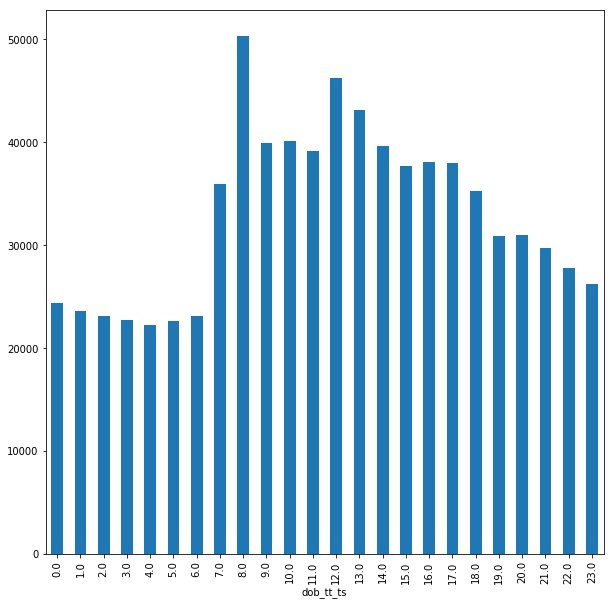

In [16]:
birthDF["dob_tt_ts"].groupby(birthDF["dob_tt_ts"].dt.hour).count().plot(
    kind="bar", 
    figsize=(10, 10)
)

## Day of the Week

First, let's just look at births on each day, you can spot the weekend pretty easily (Sunday = 0, Saturday = 6).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1286c9160>]], dtype=object)

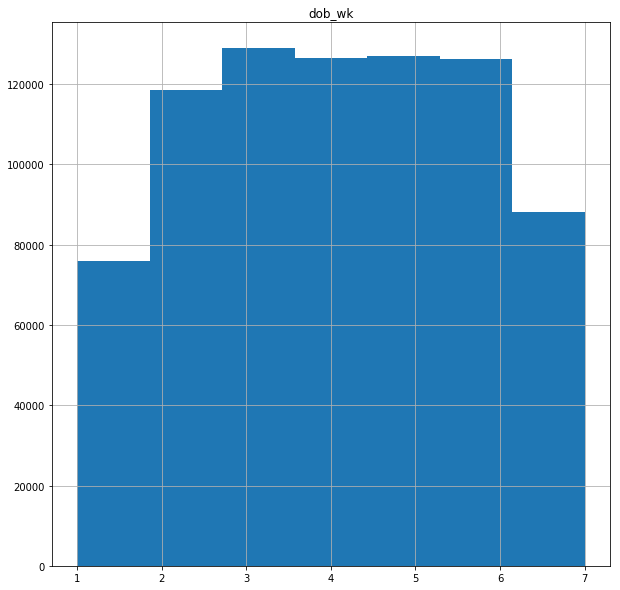

In [17]:
birthDF.hist('dob_wk', bins=7, figsize=(10, 10))

### Route 1 Births

"Route 1" corresponds to spontaneous birth, eh ... naturally. Let's restrict to route_1 births and see what that does to the day-of-the-week distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e24f160>]], dtype=object)

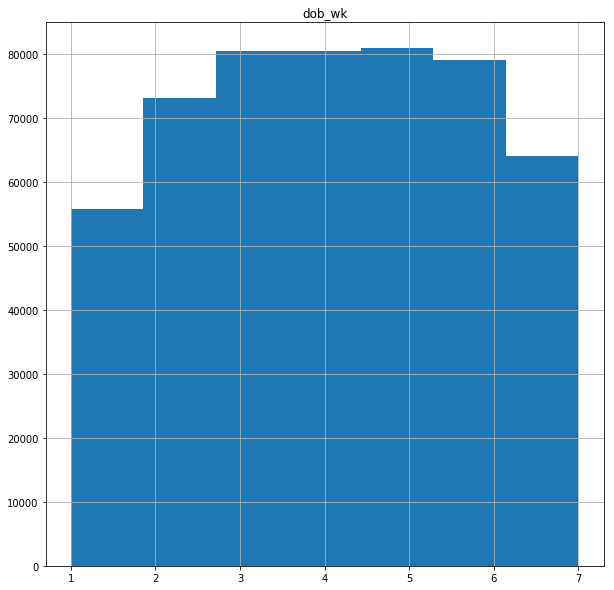

In [18]:
birthDF[birthDF['me_rout'] == 1].hist('dob_wk', bins=7, figsize=(10, 10))

### Induced Births

Now, what happens if we restrict ourselves to births which were _not_ induced

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12863e710>]], dtype=object)

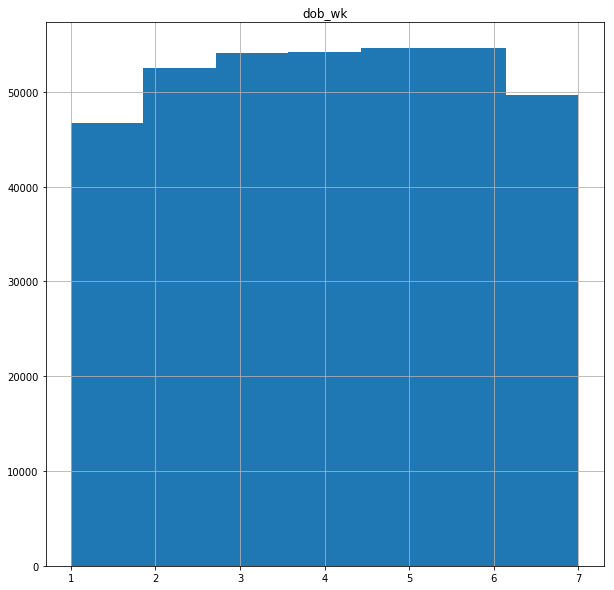

In [19]:
birthDF[(birthDF['me_rout'] == 1) & 
        (birthDF['ld_indl'] == 'N')].hist('dob_wk', bins=7, figsize=(10, 10))

That looks a bit flatter, so what happens if we pick out different "Attendant at Birth" values.

### Attendant at Birth

#### Doctors of Medicine

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1223d6710>]], dtype=object)

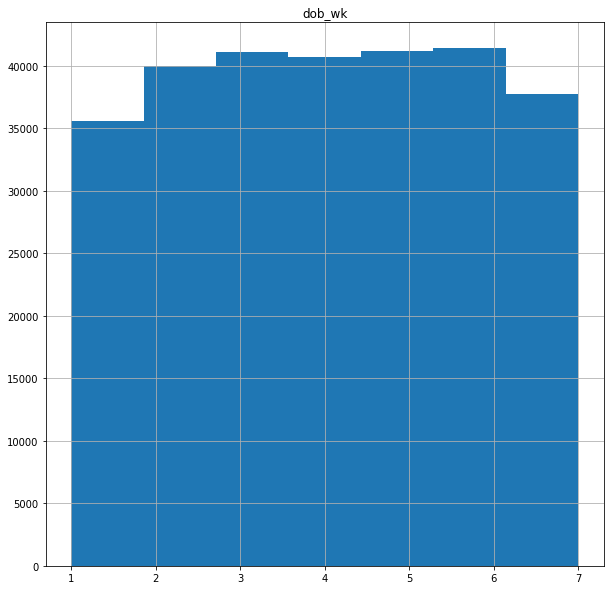

In [20]:
birthDF[(birthDF['me_rout'] == 1) & 
        (birthDF['ld_indl'] == 'N') &
        (birthDF['attend'] == 1)].hist('dob_wk', bins=7, figsize=(10, 10))

#### Doctor of Osteopathy

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117f9d6d8>]], dtype=object)

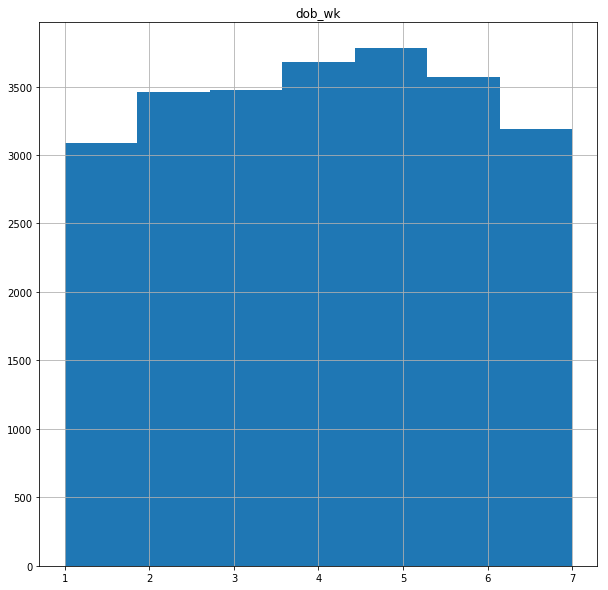

In [21]:
birthDF[(birthDF['me_rout'] == 1) & 
        (birthDF['ld_indl'] == 'N') &
        (birthDF['attend'] == 2)].hist('dob_wk', bins=7, figsize=(10, 10))

#### Certified Nurse Midwife

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ecdbc88>]], dtype=object)

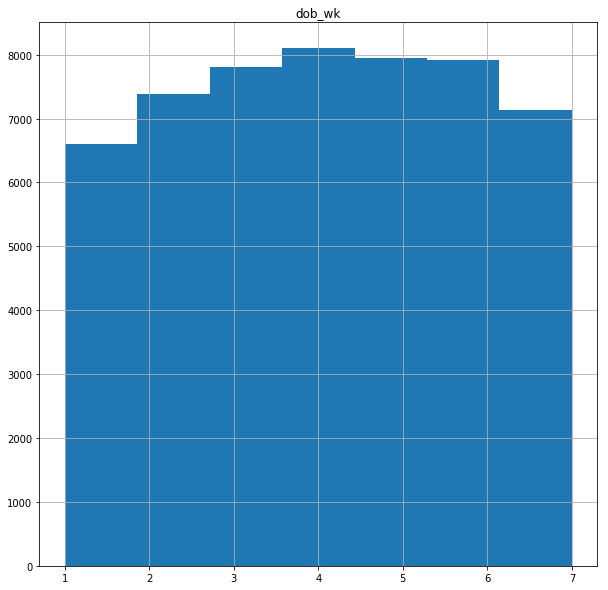

In [22]:
birthDF[(birthDF['me_rout'] == 1) & 
        (birthDF['ld_indl'] == 'N') &
        (birthDF['attend'] == 3)].hist('dob_wk', bins=7, figsize=(10, 10))

#### Other midwife

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ad78438>]], dtype=object)

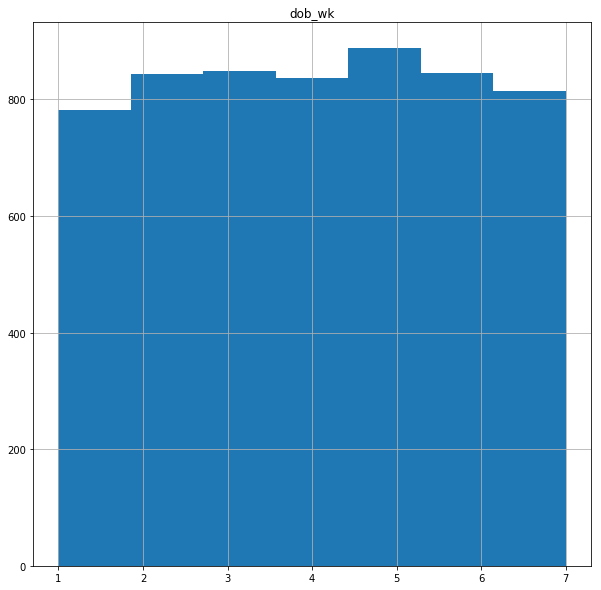

In [23]:
birthDF[(birthDF['me_rout'] == 1) & 
        (birthDF['ld_indl'] == 'N') &
        (birthDF['attend'] == 4)].hist('dob_wk', bins=7, figsize=(10, 10))

#### Other

In [ ]:
birthDF[(birthDF['me_rout'] == 1) & 
        (birthDF['ld_indl'] == 'N') &
        (birthDF['attend'] == 5)].hist('dob_wk', bins=7, figsize=(10, 10))